In [1]:
#TODO - Use GAN

import os, copy, torch, numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
from torchvision.transforms import v2
from torchvision import transforms
import torch
import torch.nn as nn
from tqdm import tqdm 
from PIL import Image

from matplotlib import pyplot as plt

device = "cuda"

In [2]:
DATASETS = "dataset/"
FRLG = DATASETS + "frlg/"
GT = DATASETS + "gt_frlg/"

ds = os.listdir(GT)
ds.remove("back")

np.random.shuffle(ds)
test, val = ds[8:], ds[:8]

len(test), len(val)

(47, 8)

In [3]:
class SatelliteDataset(Dataset):
    def __init__(self, list):
        self.img_list = []
        toTensor = transforms.ToTensor()

        for i in list:
            gt = Image.open(GT + i)
            gt = toTensor(gt.convert("RGB"))

            img = Image.open(FRLG + i)
            img = toTensor(img.convert("RGB"))

            img = torch.concatenate((img, gt), dim=0)
            self.img_list.append(img)

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        return self.img_list[idx]

train_ds = SatelliteDataset(test)
train_dl = DataLoader(train_ds, batch_size=3, shuffle=True)

val_ds = SatelliteDataset(val)
val_dl = DataLoader(val_ds, batch_size=len(val_ds), shuffle=True)

In [4]:
class RandomNoise(nn.Module):
    def __init__(self, std=0.1):
        super().__init__()
        self.std = std

    def forward(self, x):
        std = torch.rand(1).item() * self.std
        noise = torch.randn_like(x) * std
        return x + noise

train_transform1 = v2.Compose([
    v2.RandomCrop((60, 60)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    #v2.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.5),
    #v2.RandomGrayscale(p=0.2),
])

train_transform2 = v2.Compose([
    v2.RandomApply([RandomNoise(std=0.04)], p = 0.5),
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


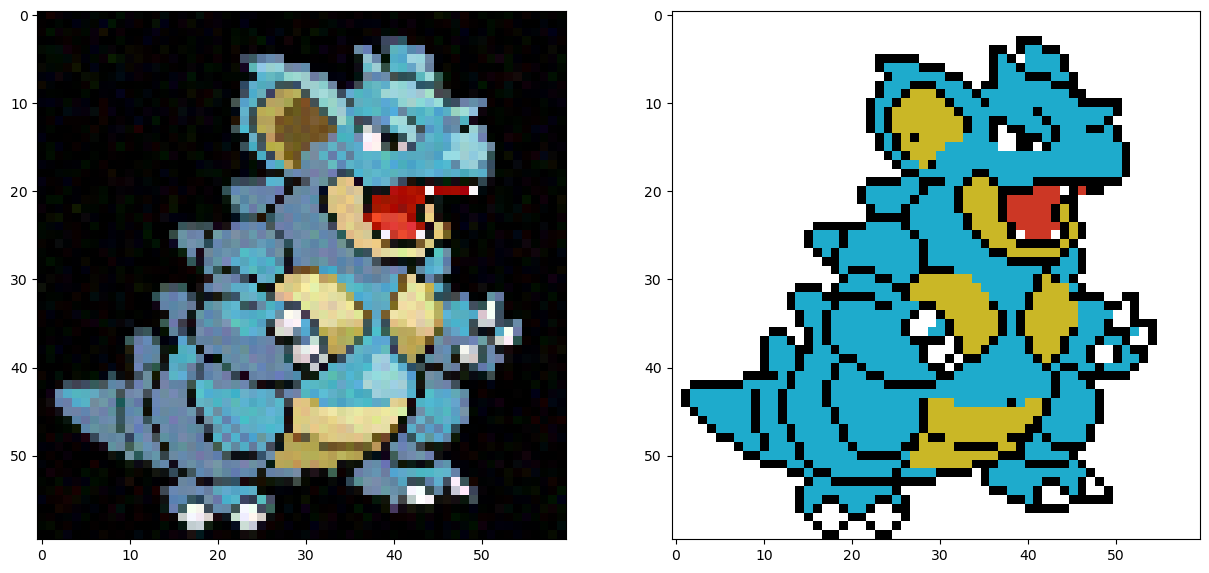

In [5]:
data = next(iter(train_dl))
data = torch.stack([train_transform1(x) for x in data])
im = data[:, :3]
lb = data[:, 3:]

im = torch.stack([train_transform2(x) for x in im])

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(im[0].permute(1, 2, 0).numpy())
axes[1].imshow(lb[0].permute(1, 2, 0).numpy())
plt.show()

In [6]:
class ConvolutionBlock(nn.Module):
    def __init__(self, in_c, out_c, kernel_size, padding='same', stride=1, dilation=1, bias=True, residual=False):
        super().__init__()

        self.residual = residual

        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 
                    kernel_size=kernel_size,
                    padding=padding,
                    padding_mode='zeros',
                    stride=stride, 
                    dilation=dilation,
                    bias=bias),
            nn.BatchNorm2d(out_c),
            nn.GELU()
        )

    def forward(self, x):
        if self.residual:
            return x + self.conv(x)
        return self.conv(x)

class ASPP(nn.Module):
    def __init__(self, in_c, out_c, residual=False):
        super().__init__()

        self.residual = residual

        self.conv1 = ConvolutionBlock(in_c, out_c, kernel_size=1)
        self.conv2 = ConvolutionBlock(in_c, out_c, kernel_size=3, dilation=3)  # 3
        self.conv3 = ConvolutionBlock(in_c, out_c, kernel_size=3, dilation=6) # 6
        self.conv4 = ConvolutionBlock(in_c, out_c, kernel_size=3, dilation=12) # 12

        self.conv6 = ConvolutionBlock(4 * out_c, out_c, kernel_size=1)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x3 = self.conv3(x)
        x4 = self.conv4(x)

        x6 = torch.cat([x1, x2, x3, x4], dim=1)
        x6 = self.conv6(x6)

        if self.residual:
            return x + x6
        
        return x6

class Network(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc = nn.Sequential(
            ConvolutionBlock(3, 32, kernel_size=1),

            ASPP(32, 32),

            ConvolutionBlock(32, 32, kernel_size=3, bias=False, residual=True),
            ConvolutionBlock(32, 32, kernel_size=3, bias=False, residual=True),
            ConvolutionBlock(32, 32, kernel_size=3, bias=False, residual=True),
            
            nn.Conv2d(32, 3, kernel_size=1),
        )

    def forward(self, x):
        x = self.enc(x)

        #return torch.sigmoid(x)
        return x

model = Network().to(device)

In [7]:
#https://www.mdpi.com/2072-4292/11/9/1015/pdf
#@torch.compile
def ssim_loss(pred, target):
    mean_pred = torch.mean(pred, dim=(1, 2, 3))
    mean_target = torch.mean(target, dim=(1, 2, 3))

    var_pred = torch.var(pred, dim=(1, 2, 3))
    var_target = torch.var(target, dim=(1, 2, 3))

    cov = torch.mean(pred * target, dim=(1, 2, 3)) - mean_pred * mean_target

    c1 = 0.01 ** 2
    c2 = 0.03 ** 2

    ssim = (2 * mean_pred * mean_target + c1) * (2 * cov + c2) 
    ssim /= (mean_pred ** 2 + mean_target ** 2 + c1) * (var_pred + var_target + c2)

    return (1 - ssim) / 2

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 0. Loss: 0.5224: 100%|██████████| 16/16 [00:00<00:00, 25.87it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.95602 *


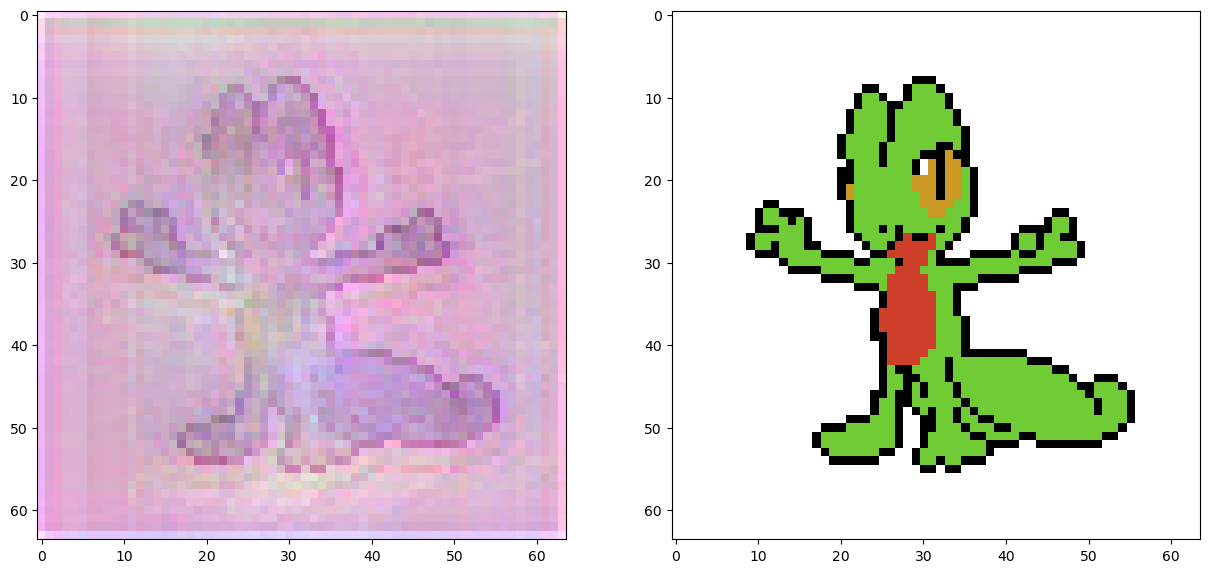

Epoch 1. Loss: 0.5782: 100%|██████████| 16/16 [00:00<00:00, 58.27it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.63011 *


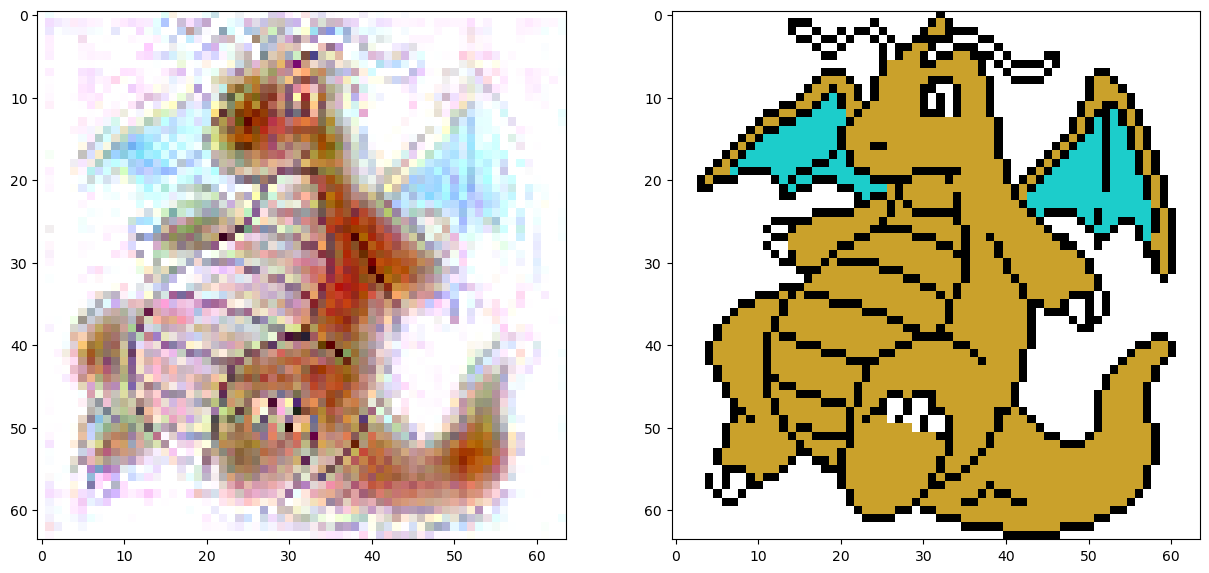

Epoch 2. Loss: 0.5962: 100%|██████████| 16/16 [00:00<00:00, 65.37it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.50642 *


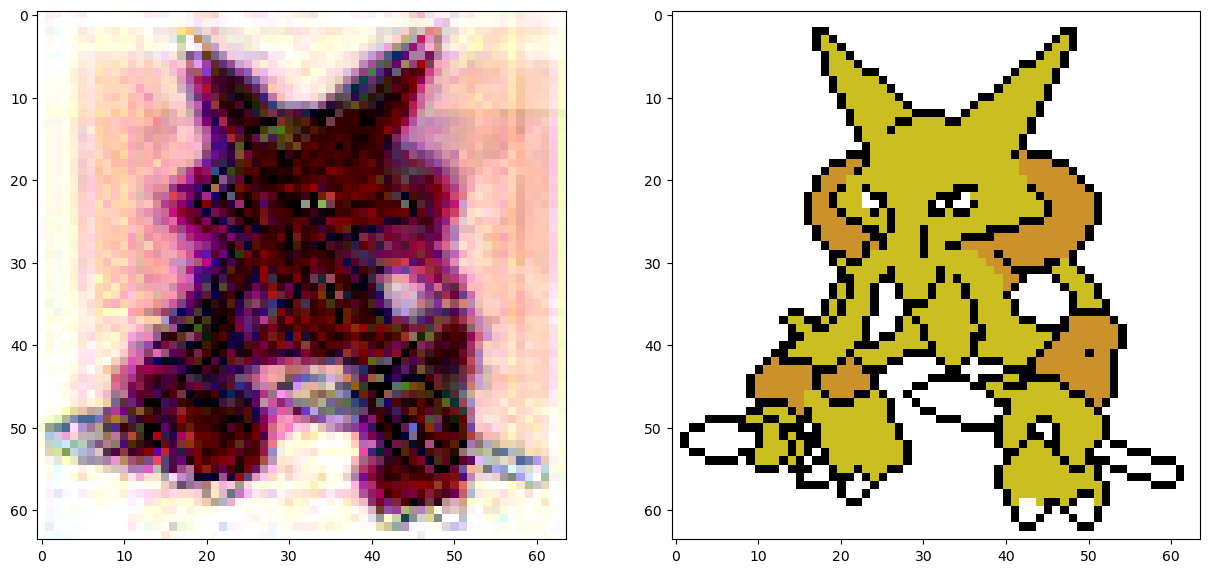

Epoch 3. Loss: 0.5131: 100%|██████████| 16/16 [00:00<00:00, 63.94it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.33447 *


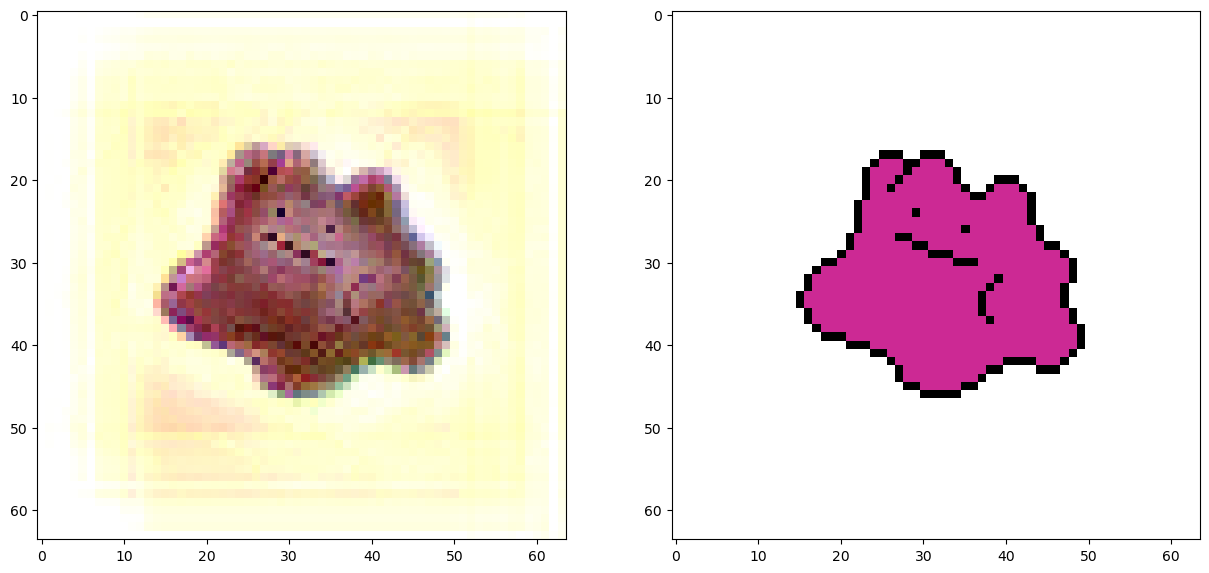

Epoch 4. Loss: 0.2955: 100%|██████████| 16/16 [00:00<00:00, 64.05it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.28166 *


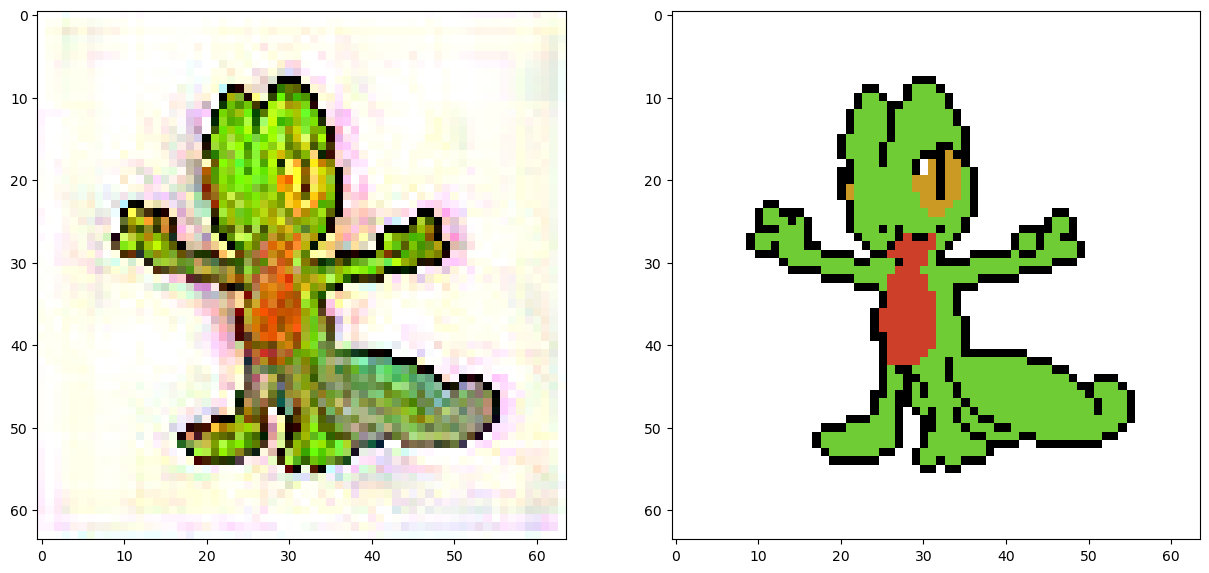

Epoch 5. Loss: 0.1981: 100%|██████████| 16/16 [00:00<00:00, 61.44it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.23249 *


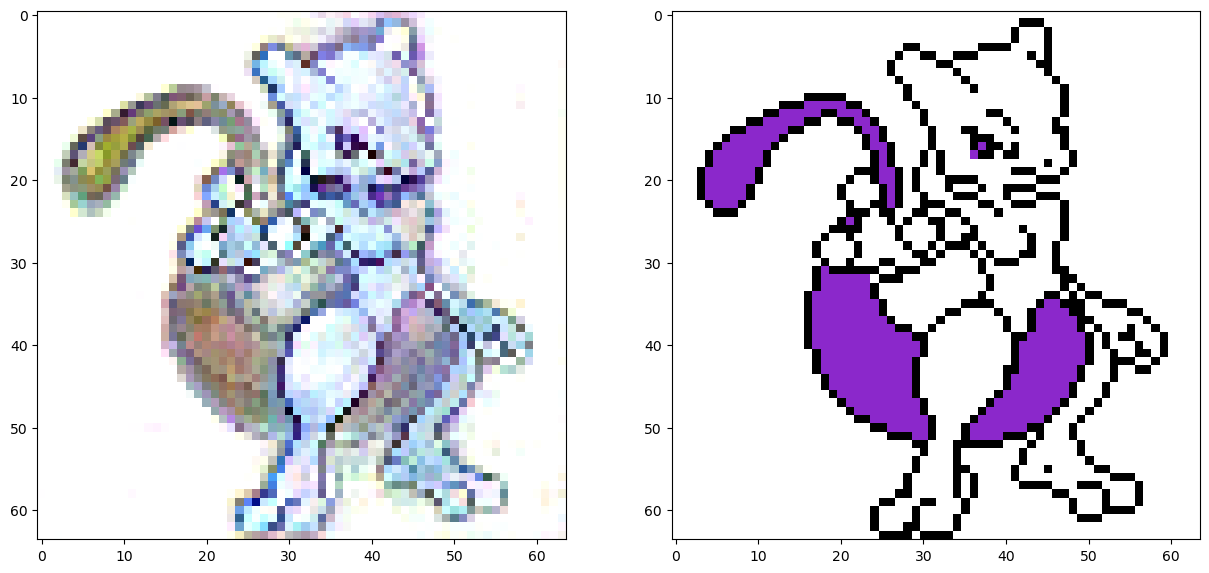

Epoch 6. Loss: 0.1401: 100%|██████████| 16/16 [00:00<00:00, 63.19it/s]


0.27483


Epoch 7. Loss: 0.1647: 100%|██████████| 16/16 [00:00<00:00, 64.13it/s]


0.26584


Epoch 8. Loss: 0.2417: 100%|██████████| 16/16 [00:00<00:00, 65.12it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.22205 *


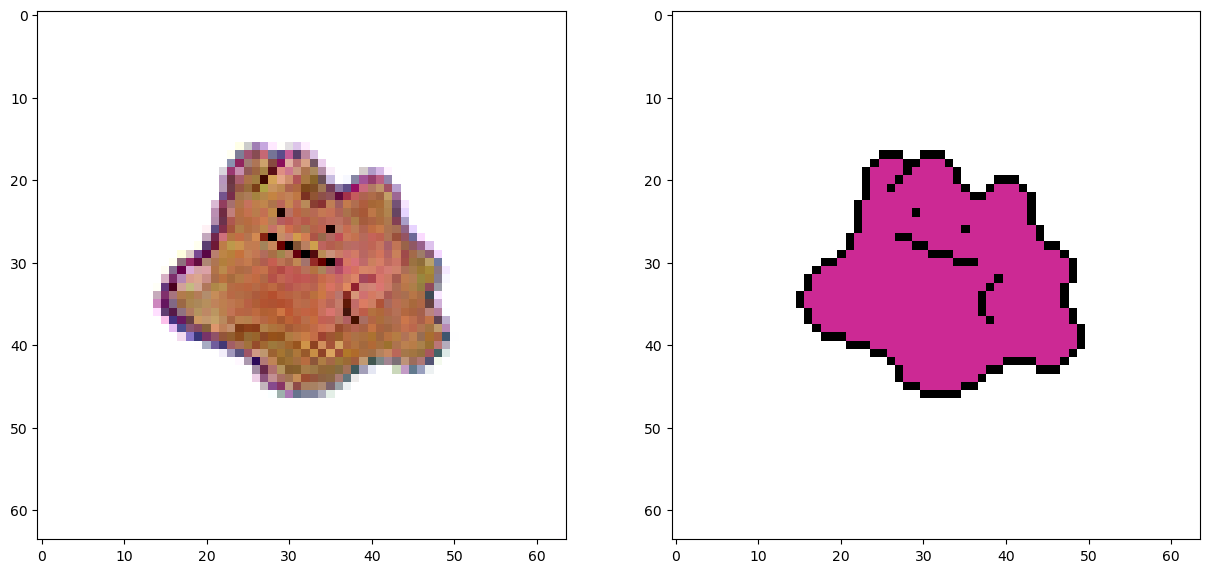

Epoch 9. Loss: 0.1599: 100%|██████████| 16/16 [00:00<00:00, 63.56it/s]


0.28403


Epoch 10. Loss: 0.2459: 100%|██████████| 16/16 [00:00<00:00, 58.13it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.21228 *


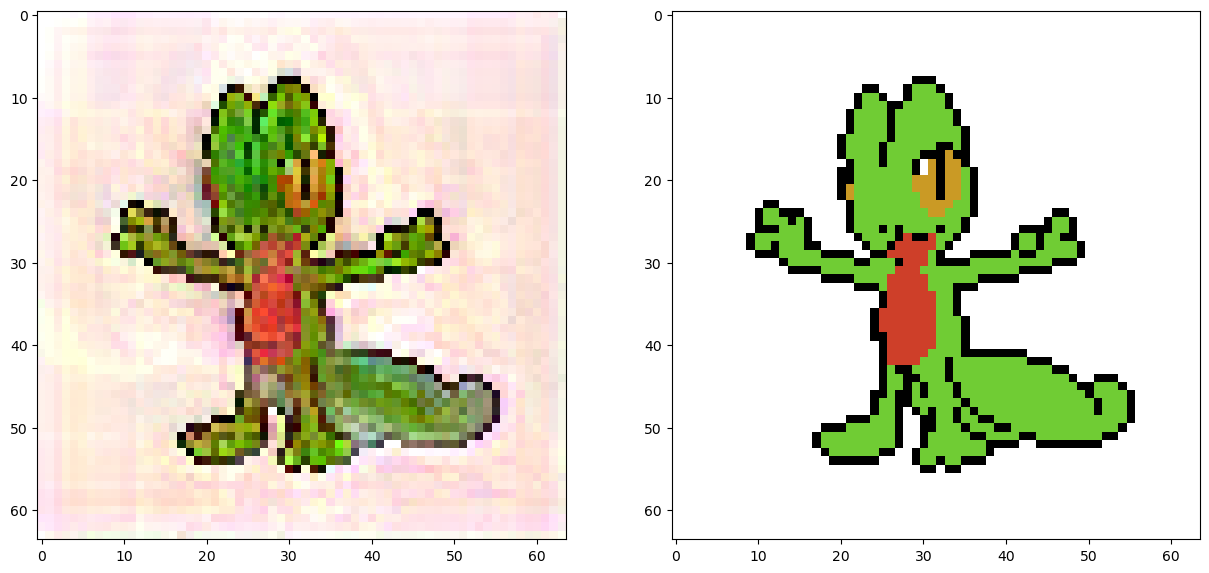

Epoch 11. Loss: 0.1059: 100%|██████████| 16/16 [00:00<00:00, 64.93it/s]


0.29986


Epoch 12. Loss: 0.1330: 100%|██████████| 16/16 [00:00<00:00, 65.46it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.21220 *


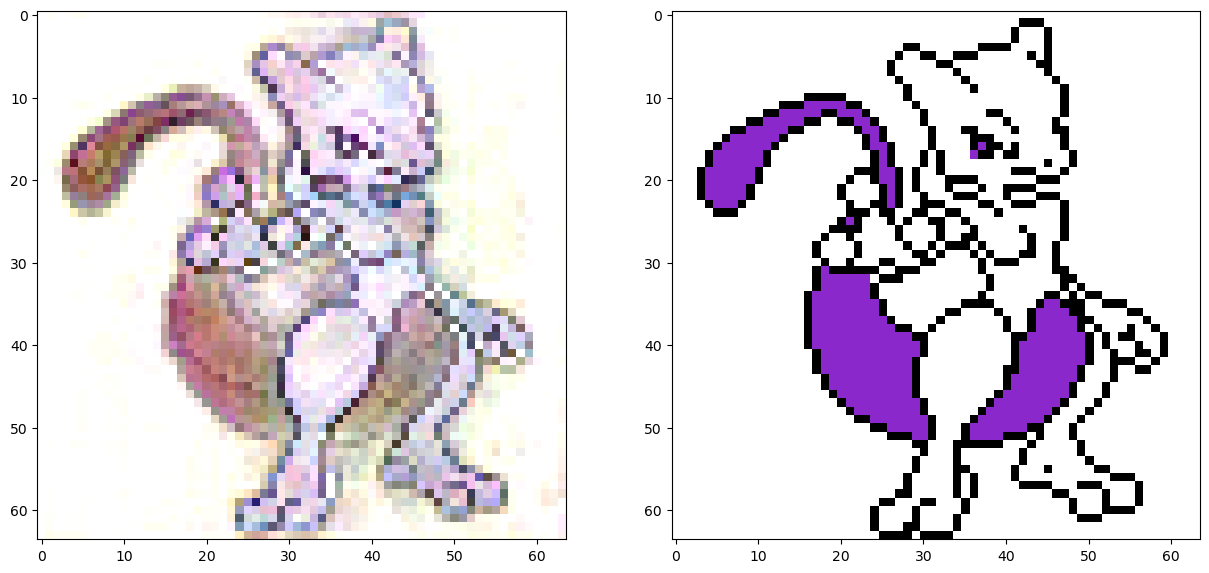

Epoch 13. Loss: 0.2493: 100%|██████████| 16/16 [00:00<00:00, 65.16it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.20888 *


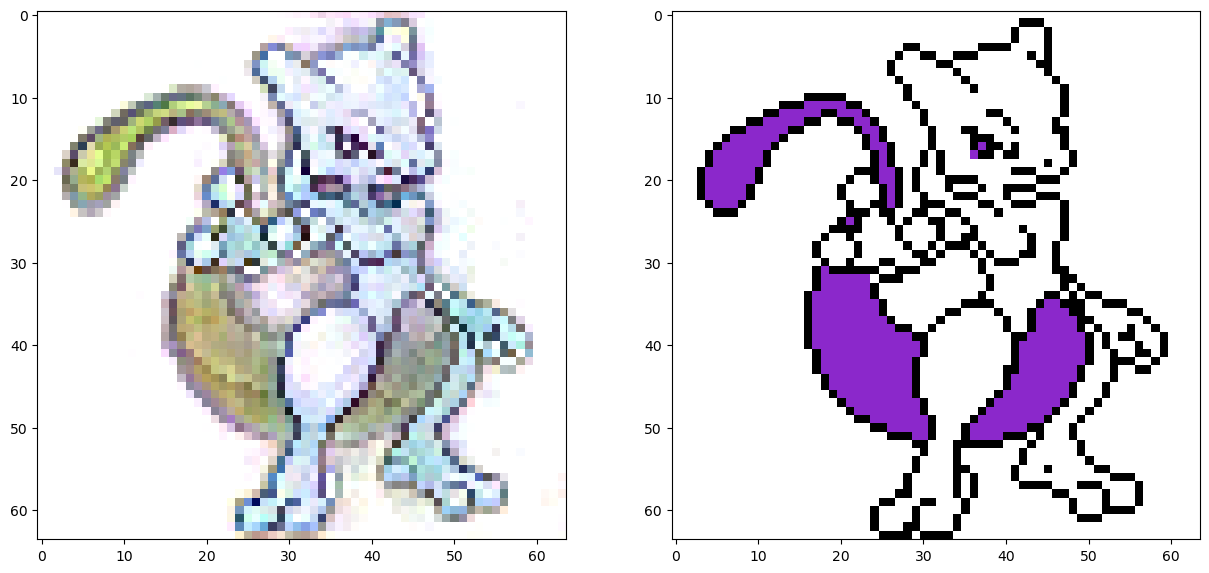

Epoch 14. Loss: 0.1684: 100%|██████████| 16/16 [00:00<00:00, 65.89it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.20391 *


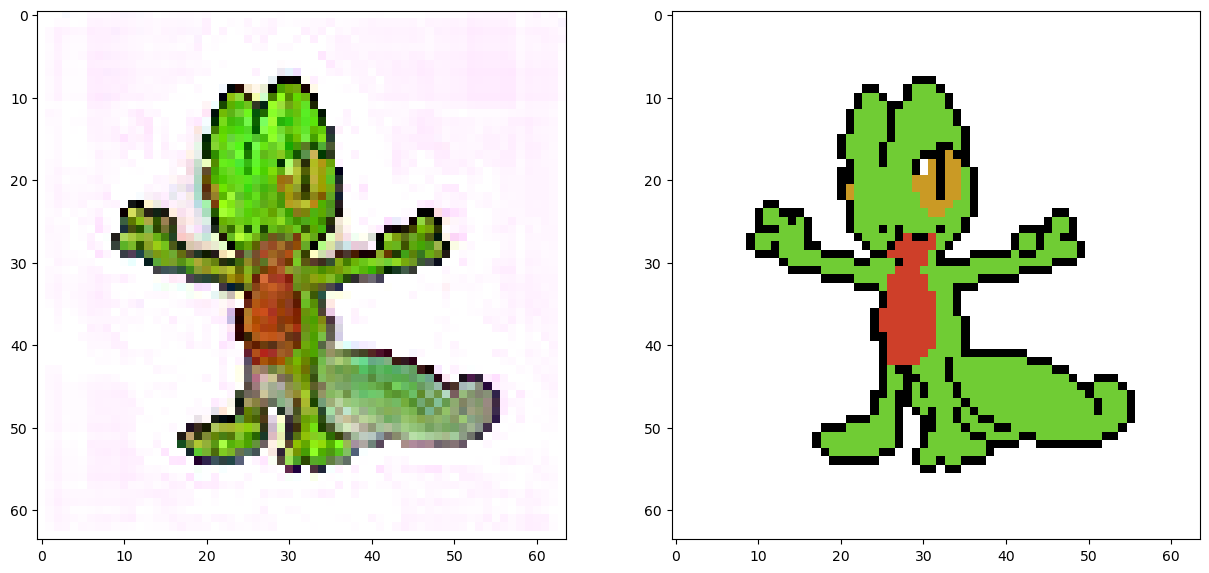

Epoch 15. Loss: 0.1337: 100%|██████████| 16/16 [00:00<00:00, 64.78it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.18259 *


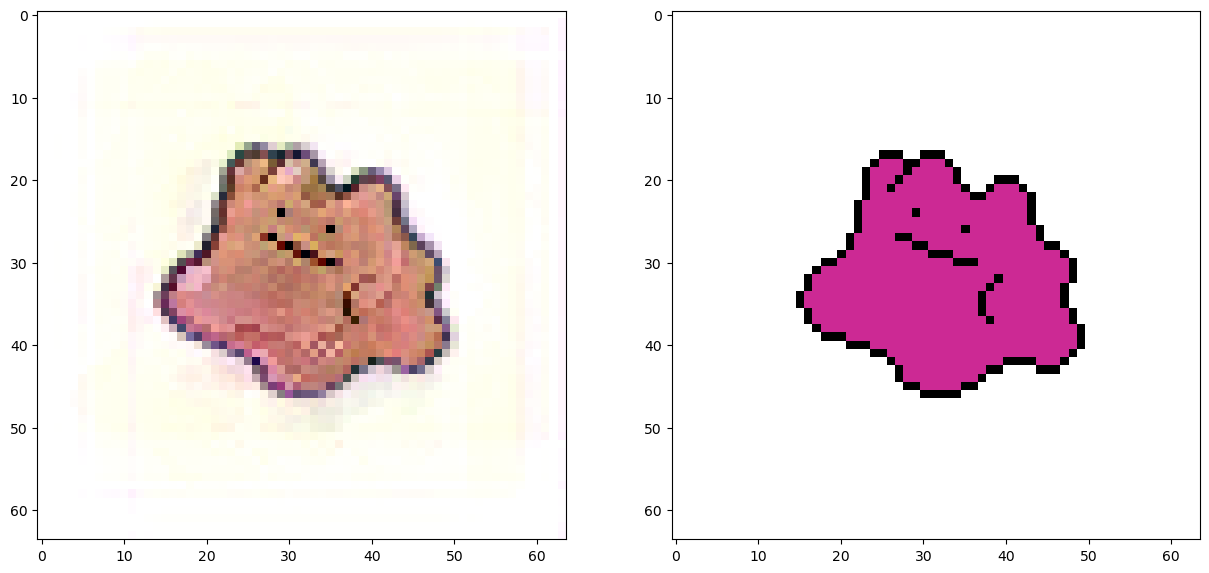

Epoch 16. Loss: 0.2501: 100%|██████████| 16/16 [00:00<00:00, 64.08it/s]


0.19499


Epoch 17. Loss: 0.1423: 100%|██████████| 16/16 [00:00<00:00, 59.63it/s]


0.18922


Epoch 18. Loss: 0.2919: 100%|██████████| 16/16 [00:00<00:00, 65.16it/s]


0.21664


Epoch 19. Loss: 0.1821: 100%|██████████| 16/16 [00:00<00:00, 61.93it/s]


0.21065


Epoch 20. Loss: 0.0889: 100%|██████████| 16/16 [00:00<00:00, 64.85it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.17502 *


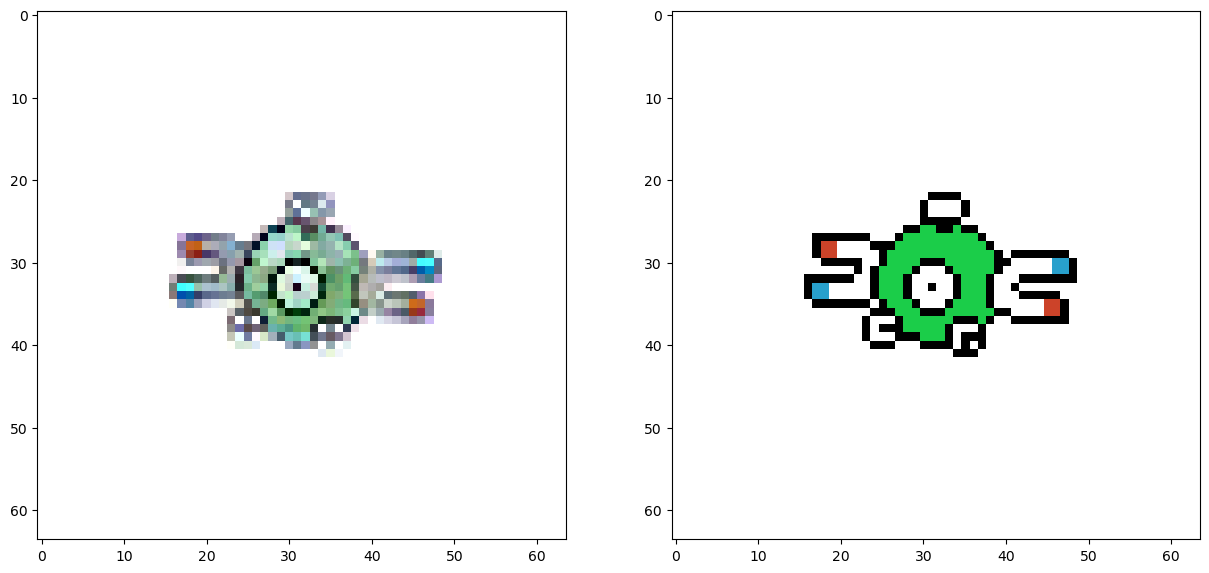

Epoch 21. Loss: 0.1543: 100%|██████████| 16/16 [00:00<00:00, 64.57it/s]


0.18683


Epoch 22. Loss: 0.2128: 100%|██████████| 16/16 [00:00<00:00, 64.54it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.16849 *


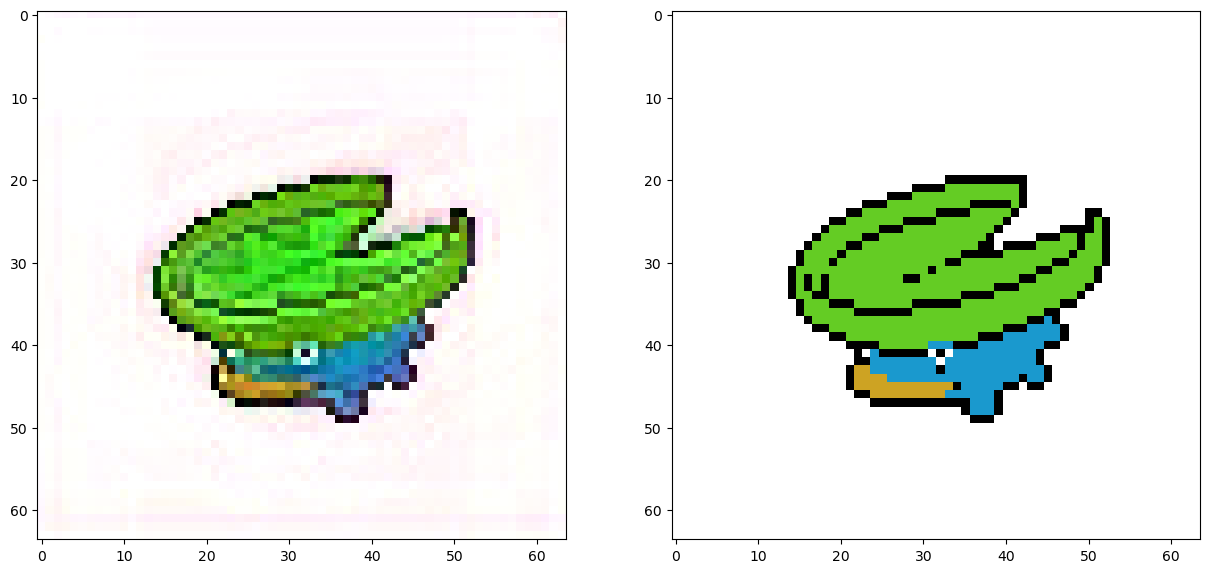

Epoch 23. Loss: 0.2147: 100%|██████████| 16/16 [00:00<00:00, 55.50it/s]


0.19603


Epoch 24. Loss: 0.1313: 100%|██████████| 16/16 [00:00<00:00, 64.14it/s]


0.18530


Epoch 25. Loss: 0.1199: 100%|██████████| 16/16 [00:00<00:00, 64.29it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.16438 *


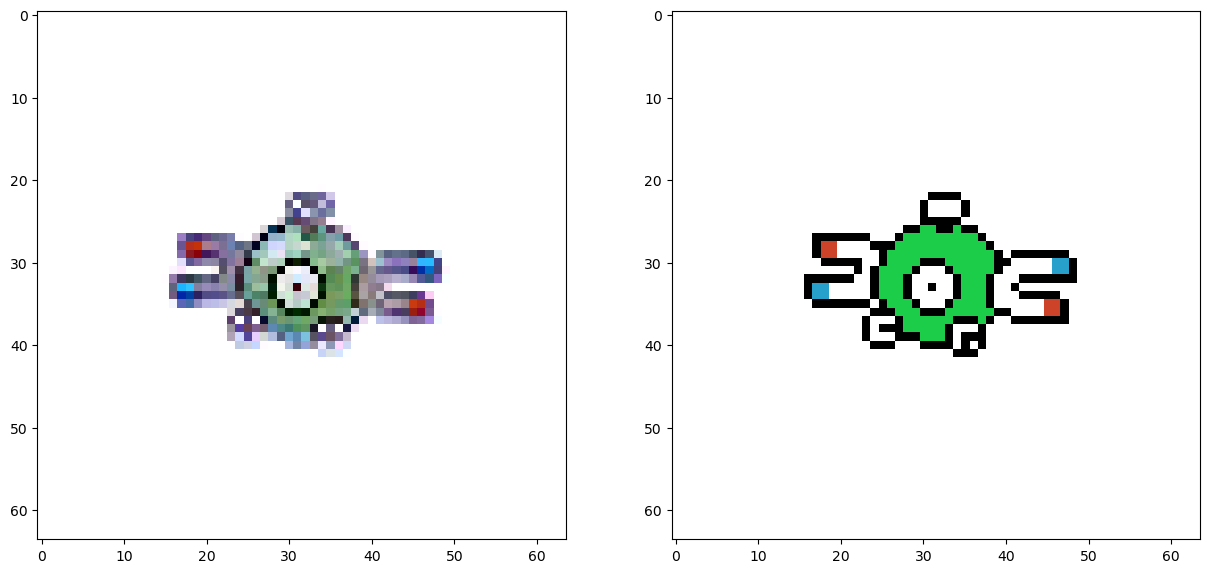

Epoch 26. Loss: 0.2747: 100%|██████████| 16/16 [00:00<00:00, 63.36it/s]


0.17412


Epoch 27. Loss: 0.0971: 100%|██████████| 16/16 [00:00<00:00, 63.77it/s]


0.17903


Epoch 28. Loss: 0.2435: 100%|██████████| 16/16 [00:00<00:00, 56.92it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.14596 *


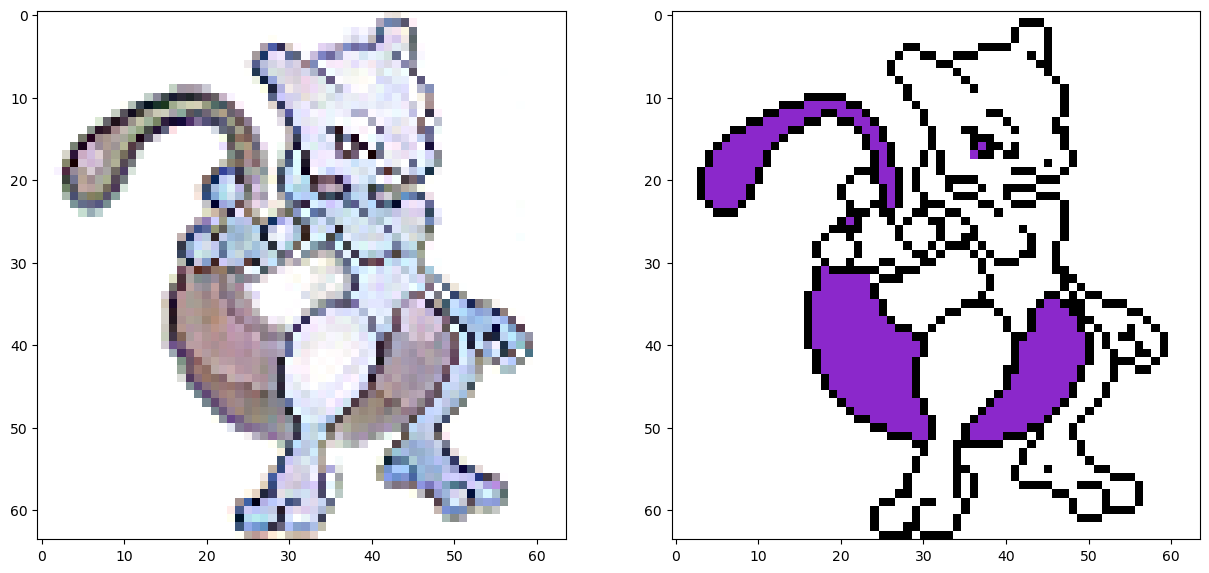

Epoch 29. Loss: 0.1230: 100%|██████████| 16/16 [00:00<00:00, 65.30it/s]


0.21683


Epoch 30. Loss: 0.0854: 100%|██████████| 16/16 [00:00<00:00, 63.54it/s]


0.16517


Epoch 31. Loss: 0.2035: 100%|██████████| 16/16 [00:00<00:00, 65.37it/s]


0.19906


Epoch 32. Loss: 0.0963: 100%|██████████| 16/16 [00:00<00:00, 66.41it/s]


0.15793


Epoch 33. Loss: 0.4259: 100%|██████████| 16/16 [00:00<00:00, 63.39it/s]


0.21908


Epoch 34. Loss: 0.0989: 100%|██████████| 16/16 [00:00<00:00, 63.77it/s]


0.17695


Epoch 35. Loss: 0.1125: 100%|██████████| 16/16 [00:00<00:00, 64.39it/s]


0.16442


Epoch 36. Loss: 0.0912: 100%|██████████| 16/16 [00:00<00:00, 65.44it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.13457 *


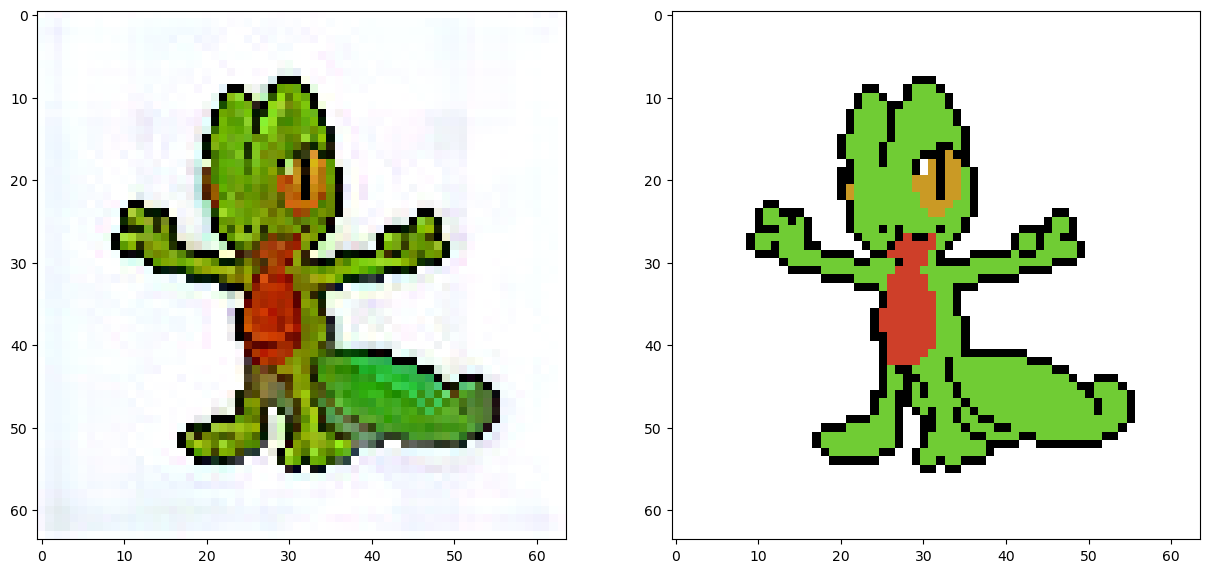

Epoch 37. Loss: 0.1334: 100%|██████████| 16/16 [00:00<00:00, 62.82it/s]


0.16322


Epoch 38. Loss: 0.1058: 100%|██████████| 16/16 [00:00<00:00, 62.42it/s]


0.24791


Epoch 39. Loss: 0.0609: 100%|██████████| 16/16 [00:00<00:00, 65.78it/s]


0.17982


Epoch 40. Loss: 0.1774: 100%|██████████| 16/16 [00:00<00:00, 65.51it/s]


0.16384


Epoch 41. Loss: 0.1284: 100%|██████████| 16/16 [00:00<00:00, 65.68it/s]


0.15479


Epoch 42. Loss: 0.1828: 100%|██████████| 16/16 [00:00<00:00, 63.84it/s]


0.14680


Epoch 43. Loss: 0.1049: 100%|██████████| 16/16 [00:00<00:00, 57.16it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.12717 *


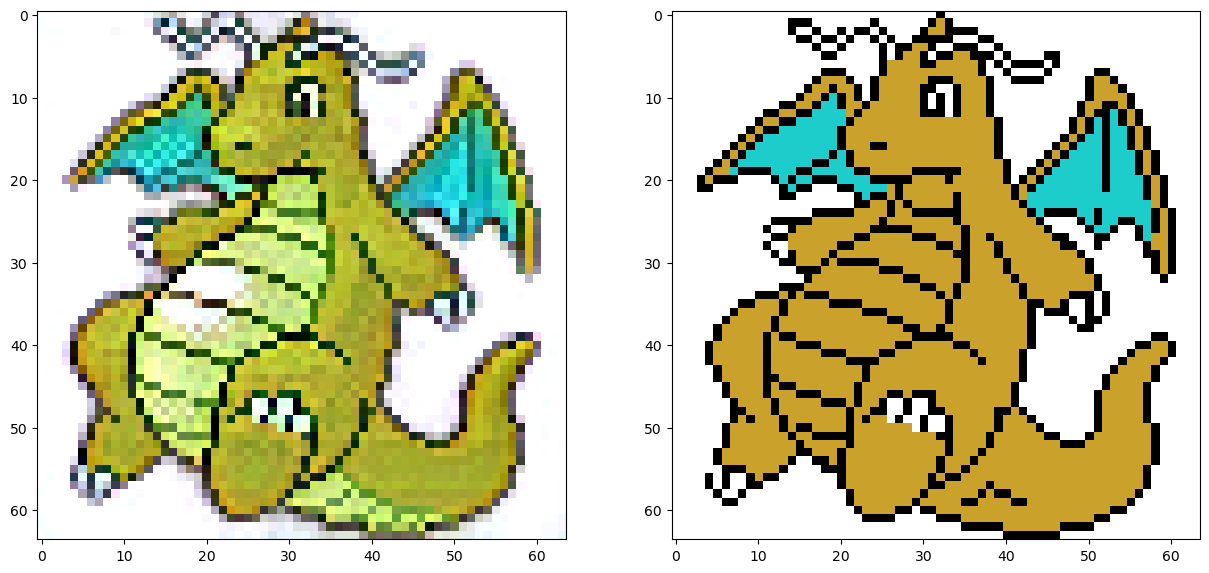

Epoch 44. Loss: 0.0735: 100%|██████████| 16/16 [00:00<00:00, 65.25it/s]


0.15216


Epoch 45. Loss: 0.1816: 100%|██████████| 16/16 [00:00<00:00, 62.66it/s]


0.17459


Epoch 46. Loss: 0.0830: 100%|██████████| 16/16 [00:00<00:00, 63.65it/s]


0.19945


Epoch 47. Loss: 0.0657: 100%|██████████| 16/16 [00:00<00:00, 63.66it/s]


0.18069


Epoch 48. Loss: 0.1154: 100%|██████████| 16/16 [00:00<00:00, 55.70it/s]


0.16991


Epoch 49. Loss: 0.2405: 100%|██████████| 16/16 [00:00<00:00, 64.97it/s]


0.19698


Epoch 50. Loss: 0.1223: 100%|██████████| 16/16 [00:00<00:00, 64.22it/s]


0.19540


Epoch 51. Loss: 0.2036: 100%|██████████| 16/16 [00:00<00:00, 65.24it/s]


0.13861


Epoch 52. Loss: 0.0792: 100%|██████████| 16/16 [00:00<00:00, 60.55it/s]


0.15288


Epoch 53. Loss: 0.2252: 100%|██████████| 16/16 [00:00<00:00, 59.33it/s]


0.15045


Epoch 54. Loss: 0.1124: 100%|██████████| 16/16 [00:00<00:00, 65.03it/s]


0.21075


Epoch 55. Loss: 0.1253: 100%|██████████| 16/16 [00:00<00:00, 65.66it/s]


0.21513


Epoch 56. Loss: 0.1647: 100%|██████████| 16/16 [00:00<00:00, 64.00it/s]


0.24094


Epoch 57. Loss: 0.1891: 100%|██████████| 16/16 [00:00<00:00, 63.88it/s]


0.24481


Epoch 58. Loss: 0.0895: 100%|██████████| 16/16 [00:00<00:00, 58.80it/s]


0.13439


Epoch 59. Loss: 0.1840: 100%|██████████| 16/16 [00:00<00:00, 64.16it/s]


0.20711


Epoch 60. Loss: 0.0964: 100%|██████████| 16/16 [00:00<00:00, 64.02it/s]


0.17341


Epoch 61. Loss: 0.1628: 100%|██████████| 16/16 [00:00<00:00, 64.16it/s]


0.24047


Epoch 62. Loss: 0.1796: 100%|██████████| 16/16 [00:00<00:00, 63.93it/s]


0.31471


Epoch 63. Loss: 0.1068: 100%|██████████| 16/16 [00:00<00:00, 62.26it/s]


0.19322


Epoch 64. Loss: 0.1204: 100%|██████████| 16/16 [00:00<00:00, 62.18it/s]


0.21715


Epoch 65. Loss: 0.0780: 100%|██████████| 16/16 [00:00<00:00, 64.07it/s]


0.16930


Epoch 66. Loss: 0.1565: 100%|██████████| 16/16 [00:00<00:00, 63.41it/s]


0.23022


Epoch 67. Loss: 0.1415: 100%|██████████| 16/16 [00:00<00:00, 65.15it/s]


0.17862


Epoch 68. Loss: 0.0677: 100%|██████████| 16/16 [00:00<00:00, 60.84it/s]


0.22892


Epoch 69. Loss: 0.1026: 100%|██████████| 16/16 [00:00<00:00, 63.24it/s]


0.18506


Epoch 70. Loss: 0.1133: 100%|██████████| 16/16 [00:00<00:00, 62.93it/s]


0.28810


Epoch 71. Loss: 0.0806: 100%|██████████| 16/16 [00:00<00:00, 63.89it/s]


0.19450


Epoch 72. Loss: 0.0650: 100%|██████████| 16/16 [00:00<00:00, 62.96it/s]

0.14709
Patience ended.


<All keys matched successfully>

In [8]:
model.train()

mse_loss = nn.MSELoss()
loss_fn = lambda output, target: mse_loss(output, target) + 2 * ssim_loss(output, target)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

epochs = 500
patience = 30

best_loss = torch.inf
best_model = copy.deepcopy(model.state_dict())
pat_count = 0

val_losses = []

for i in range(epochs):
    model.train()

    # Train
    pbar = tqdm(train_dl)
    for data in pbar:
        optimizer.zero_grad()
        
        data = data.to(device)
        data = torch.stack([train_transform1(x) for x in data])
        im = data[:, :3]
        lb = data[:, 3:]

        im = torch.stack([train_transform2(x) for x in im])

        out = model(im)
        loss = loss_fn(out, lb).mean()
        pbar.set_description(f"Epoch {i}. Loss: {loss:.4f}", refresh=False)
        
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        model.eval()

        data = next(iter(val_dl)).to(device)
        im = data[:, :3]
        lb = data[:, 3:]

        out = model(im)
        loss = loss_fn(out, lb).mean()

        if loss <= best_loss:
            best_loss = loss
            best_model = copy.deepcopy(model.state_dict())
            pat_count = 0
            print(f'{loss:.5f} *')

            fig, axes = plt.subplots(1, 2, figsize=(15, 10))
            axes[0].imshow(out[0].cpu().permute(1, 2, 0).numpy(), vmin=0, vmax=1)
            axes[1].imshow(lb[0].cpu().permute(1, 2, 0).numpy(), vmin=0, vmax=1)
            plt.show()
        else:
            print(f'{loss:.5f}')

        val_losses.append(loss)

        pat_count = pat_count + 1
        if pat_count == patience:
            print("Patience ended.")
            break

model.load_state_dict(best_model)

In [9]:
raise Exception("Stop here")

# save model with jit
model.eval()
model = torch.jit.script(model)
model.save("contour_model.pt")

Exception: Stop here

In [ ]:
src = "dataset/emerald/"
dst = "dataset/emerald_cont/"

os.makedirs(dst, exist_ok=True)

imgs = os.listdir(src)
if "back" in imgs:
    imgs.remove("back")

for i in imgs:

    toTensor = transforms.ToTensor()
    img = Image.open(src + i)
    img = toTensor(img.convert("RGBA"))
    
    alpha = img[[3]]
    img = img[[0,1,2]] * alpha
    img += 1 - alpha

    out = model(img[None, ...])[0]

    toPIL = transforms.ToPILImage(mode="L")
    img = toPIL(out)
    img.convert("RGB").save(dst + i)
